# Comprehensive Guide on Using Time Travel Feature in Snowflake


## What is Time Travel in Snowflake?

Just like software engineers have Git for version control, data engineers have Time Travel in Snowflake databases. The Time Travel feature allows database administrators to query historical data, clone old tables and restore objects dropped in the past.

But given the massive sizes databases can grow into, Time Travel is not a drop-in equivalent of code version control. Every time a table is modified (deleted or updated), Snowflake takes a snapshot of the data's state before the update. This snapshot only lives for a specified number of days called data retention period. 

For Snowflake Standard accounts, the maximum retention period is only a single day. For Enterprise accounts, the retention period can be anywhere between 0 and 90 days. A retention period of 0 effectively disables Time Travel, which is enabled for all tables by default.

## Snowflake Time Travel vs. Fail-safe

While reading [the Snowflake docs](https://docs.snowflake.com/en/), you might come across the term "Fail-safe" as well. From the names, it may sound that both Time Travel and Fail-safe features do the same task but they do not. 

When an object finishes its retention period, it is then moved into Snowflake Fail-safe. In Fail-safe, you cannot:
- Query historical data
- Clone past objects
- Restore past objects that were dropped

Fail-safe only keeps the data for a non-configurable 7 day period. During this period, the data can be recovered only by Snowflake itself. This feature is put into place as a data recovery service and only intended as a last resort when all recovery methods fail. It is for use only when data has been damaged or deleted due to operational failures.

So, you cannot ask Snowflake to recover past versions of your objects once they live out their determined retention period naturally. Keep this rule in mind while following along this tutorial.

## Setting up the environment

Snowflake has two interfaces to interact with the platform - SnowSight (the web UI) and SnowSQL (the terminal client). We will go forward with SnowSight as it is easier to set up. You can read [this comprehensive tutorial](https://www.datacamp.com/tutorial/introduction-to-snowflake-for-beginners) if you are new to Snowflake. It covers how to use SnowSQL as well. 

First, sign up for a free account from [the Snowflake homepage](https://www.snowflake.com/en/). You will be able to access Enterprise features for a 30-day free trial.

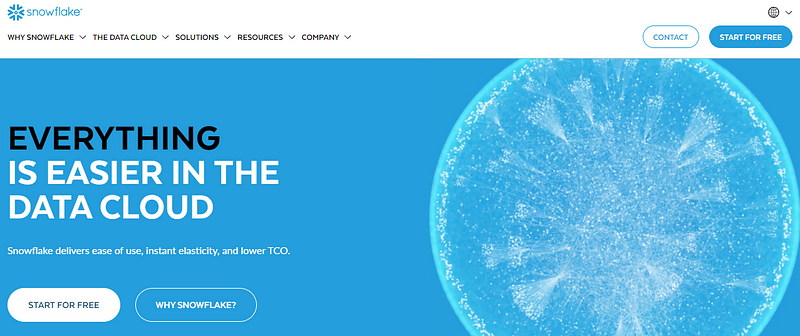

Once your account is ready, you will be directed to your dashboard's Worksheets page. You can think of each worksheet as a separate environment to run SQL or even Python.

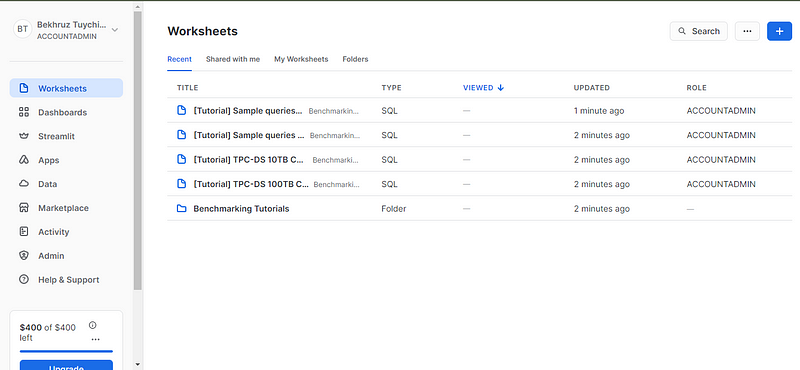

Now, create a new worksheet using the "+" button in the top right:

![](images/new_worksheet.gif)

Next, let's create some databases and tables and populate them with data. 

## Creating the database and tables

First, we will create a database named `ecommerce_db`. Paste the following code and press "Ctrl + Enter" (Cmd + Enter) to run it ("Ctrl + Shift + Enter" runs the entire worksheet statements). 

```sql
CREATE DATABASE IF NOT EXISTS ecommerce_db;
```

We will use this hypothetical database to sell AI-related merchandise. Run the below command to set it as default:

```sql
USE DATABASE ecommerce_db;
```

First, we will create a table named `inventory` with three columns:

```sql
CREATE OR REPLACE TABLE inventory (
  product_id INT PRIMARY KEY,
  name VARCHAR(255),
  stock_level INT,
  last_updated TIMESTAMP_TZ DEFAULT CURRENT_TIMESTAMP
);
```

Then, we will add some starting products:

```sql
INSERT INTO inventory (product_id, name, stock_level)
VALUES (1, Llama hoodiet', 10), (2, Falcon capt', 20);
```

We will also create a table for orders:

```sql
CREATE OR REPLACE TABLE orders (
  order_id INT PRIMARY KEY,
  product_id INT REFERENCES inventory(product_id),
  quantity INT,
  order_date TIMESTAMP_TZ DEFAULT CURRENT_TIMESTAMP
);
-- Assume some time passes after this table was created
```

After we put up a website to sell our merchandise, we receive some offers. In the morning, we receive two orders for both our products:

```sql
INSERT INTO orders (order_id, product_id, quantity)
VALUES (1, 1, 5), (1, 2, 3);;

```

In the afternoon, we receive another:

```sql
-- Simulate a system glitch causing an extra order for product 1
INSERT INTO orders order_id, (product_id, quantity)
VALUES3,  (1, 100);  -- This might cause negative stock
```

But due to a system glitch, the order is recorded for more stock than we have. Let's pretend that we didn't find this out for two weeks.

> Note that I made a few other updates to tables under the hood.

## Controlling retention period

Our first task is setting a retention period. My free trial had ended, so I can only set it for one day:

```sql
ALTER TABLE inventory SET DATA_RETENTION_TIME_IN_DAYS=1;
ALTER TABLE orders SET DATA_RETENTION_TIME_IN_DAYS=1;
```

If yours hasn't ended, try setting to four weeks as your trial will run out after that time. 

## Using `AT` and `BEFORE` clauses

Snowflake implements Time Travel through these SQL extensions:
- `AT` and `BEFORE` clauses to use in `SELECT` statements to pinpoint the exact point (or period) in time you are try to query. They support these parameters to execute this task:
  - `TIMESTAMP`
  - `OFFSET` - time difference in seconds from the present time
  - `STATEMENT` - unique query ID
- `UNDROP` command to restore tables, schemas and databases

Let's see how to use these extensions on our sample database.

### Querying historical data

First, let's observe what we have in `inventory`:

```sql
-- Check current stock level (might show negative value)
SELECT * FROM inventory;
```

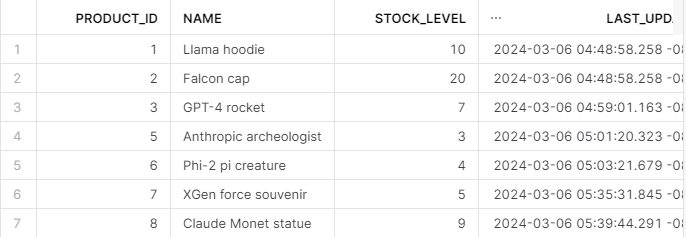

Now, let's combine the orders and inventory we have:

```sql
SELECT i.name, i.stock_level, o.quantity as "order_amount"
  FROM inventory as i
  JOIN orders as o
    ON i.product_id = o.product_id;
```

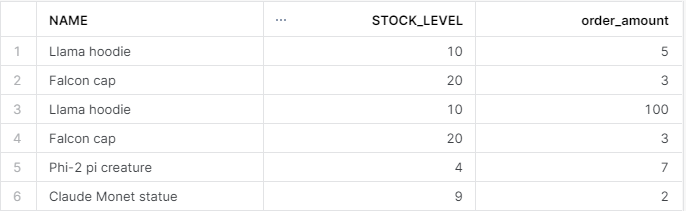

Uh-oh! Looks like there is an error - the amount of Llama hoodie orders is more than we have. Let's try to go back 17.5 to pinpoint the exact time this erroneous statement was executed:

```sql
SELECT * FROM orders AT(OFFSET => -60*60*17.5); -- Go back 17.5 hours back
```

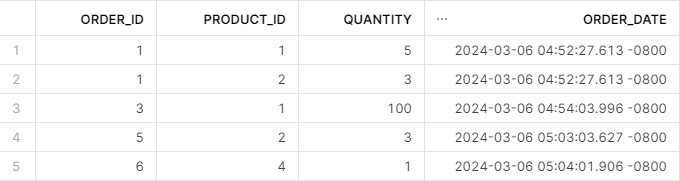

So, the incorrect order was placed at 4.54 PM on the 6th of March. This means we need the table's state before that time. That is easy to query with the `BEFORE` clause:

```sql
-- Change the timezone
ALTER SESSION  SET TIMEZONE = 'UTC';

-- Select the table state before the error
SELECT * FROM orders BEFORE(TIMESTAMP => '2024-03-06 04:54:00 -0800'::timestamp_tz);
```

> Don't forget to add `timestamp_tz` as a data type for the time stamp. `tz` stands for time zone.

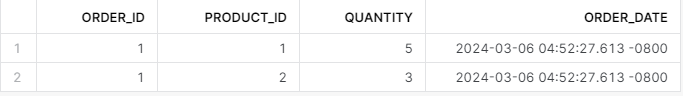

These examples demonstrate how to use `AT` and `BEFORE` clauses with timestamps and offsets. If you don't want to have to figure out the timing of queries, you can use statement IDs. For example, the below query executes the same task as the last one - query the table state before the incorrect order was placed:

```SQL
SELECT * FROM orders BEFORE(STATEMENT => '01b2ce86-0000-95e2-0000-000669127035');
```

Here is how you can find the query ID of any statement:

![](images/find_id.gif)

By filtering the type of queries, you can find the one you are looking for much faster in SnowSight. 

### Cloning historical objects

So, we have an incorrect order in our table - how to get rid of it? 

Well, one thing we could try is cloning the table without the incorrect row:

```sql
CREATE OR REPLACE TABLE orders_clone AS
SELECT * FROM orders WHERE quantity != 100;

SELECT * FROM orders_clone;
```

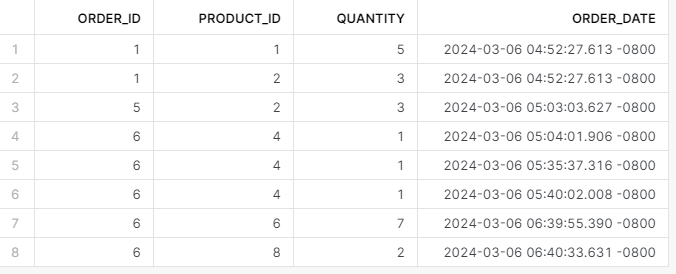

It worked and we didn't have to rely on Time Travel to fix the issue. But when you need to clone past states of a table, here is a syntax you can follow:

```sql
-- Clone an object as it existed 2 days ago
CREATE TABLE old_table_clone CLONE olt_table
    AT(OFFSET => -2 * 24 * 60 * 60);  -- Offset for 2 days
```

Cloning databases is similar:

```sql
CREATE DATABASE cloned_db CLONE my_db
  BEFORE(STATEMENT => '8e5d0ca9-005e-44e6-b858-a8f5b37c5726');
```

### Dropping and restoring objects

Let's say we just hired an intern - Chandler and gave him the problem we had with the incorrect order. 

By trying to remove that record, Chandler accidentally drops the `orders` table in production:

```sql
-- Simulate accidentally dropping the orders table
DROP TABLE orders

SELECT * FROM orders;;
```

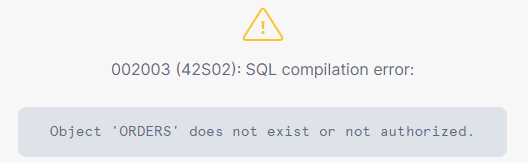

Chandler approaches us, totally freaked out, and tells what he did. So, we calmly execute the `UNDROP` command:

```sql
-- Recover the dropped table using UNDROP
UNDROP TABLE orders

SELECT * FROM orders;;
```

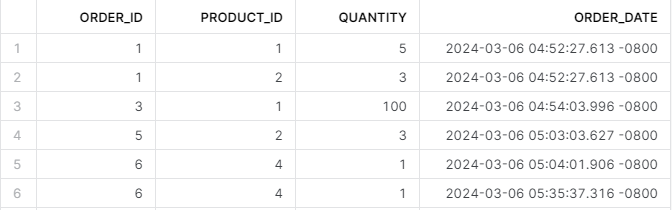

And get the table back. We also forgive Jon and decide not to fire him for his mistake.

## Conclusion

In this tutorial, we've learned about a key feature in Snowflake - Time Travel. Using Time Travel, you can query and restore past information, which is a highly thought-after feature in database management tools. Anything can happen in production environments and having a backup of your database before each update gives you a sense of calm. 

I think Snowflake is the best database management tool out there. It is a massive tool and mastering it is a desirable kill in data roles. So, if you want to learn more about it, check out the [Introduction to Snowflake course](https://www.datacamp.com/courses/introduction-to-snowflake) on DataCamp.

If you are already comfortable with it and want to test your skills, take a look at [the best Snowflake certifications](https://www.datacamp.com/blog/best-snowflake-certification) available in 2024.

Thank you for reading!